# MendelGeneticCounseling ASHG Workshop
### last update: September 12 2019, 3:20 pm. 

The purpose of this tutorial is to demonstrate how to calculate genetic risks for individuals using their family histories and covariate information. 

##  Commands starting with ";" are Mac shell commands that should work with a PowerShell on Windows. If using a Dos cmd window use "type" rather than "cat". 

## Installation instructions (not needed during workshop)

`MendelGeneticCounseling.jl#ASHG2019` currently supports Julia versions 1.0, 1.1 and 1.2, but it is currently an unregistered package. To install, press `]` to invoke the package manager mode and install these packages by typing:

```
add https://github.com/OpenMendel/SnpArrays.jl
add https://github.com/OpenMendel/MendelSearch.jl
add https://github.com/OpenMendel/MendelBase.jl
add https://github.com/OpenMendel/MendelGeneticCounseling.jl#ASHG2019
build SpecialFunctions

```

Be sure also to download the BRCA and Cholesterol data from https://github.com/OpenMendel/GeneticCounseling_ASHG2019. For convenience, have your input files and this notebook in the same directory.  

### NOTE: When finished with this notebook, go to the File tab and first select save and checkpoint to save your results. Then under the file tab, select close and halt to prevent copies of Jupyter notebook from running indefinitely in the background. 

## Check Julia version:
For reproducibility, check the machine information below. To execute a notebook command, hold down`Shift Enter` within the box.  This tutorial and corresponding modules have been checked with Julia versions 1.0, 1.1 and 1.2.  Please report any issues running the tutorial or the module to Janet Sinsheimer PhD. (jsinshei@g.ucla.edu).

In [ ]:
versioninfo()

## When to use MendelGeneticCounseling

`MendelGeneticCounseling.jl` is capable of calculating the risk of an underlying genotype (e.g. Homozygous_Normal, Heterozygous, Homozygous_Mutant) given a family history and individual risk factors including closely linked genetic markers.  It can use parametric models or a penetrance file. 

Example 1 uses a parametric model.  The parametric models are currently restricted to the following generalized linear model distributions, binomial, exponential, gamma, inverse gaussian, logistic, lognormal, negative binomial, Poisson, and of course, the normal distributions but more distributions can be added to the `apply_dist.jl` function. The inverse link functions available are for the links: log, logit, cauchit, complementary log log, inverse (1/x), probit, and square root. More can be added to `apply_inverse_link_new.jl`. We will be adding the capability to run censored survival models soon. 

`MendelGeneticCounseling.jl` is also capable of using a penetrance file that provides the probability that an individual is affected conditional their genotype and risk factors (Example 2).

This module is a prototype and features will be added. Currently we are working on models that can handle censoring, data in snp binary or vcf files, and mutation at the risk locus. 

### Analysis keywords needed for a glm penetrance function.
| Keyword | Default Value | Allowed value | Description |
| --- | --- | --- | --- |
|`glm_mean` | 0.0 | symbolic expression | provides the form of x^b |
|`glm_response`| "Normal" | GLM distribution | One of the following distribution choices: Binomial, exponential, gamma, inverse Gaussian, logistic, lognormal, negative binomial, Poisson, normal  |
|`glm_link` | "IdentityLink" | Inverse Link Function for the appropriate GLM link|  CauchitLink,CloglogLink, IdentityLink, InverseLink, LogitLink, LogLink, ProbitLink, Sqrt |
|`glm_trait`| Affected| String| Defines the column in the pedigree file that contains the trait phenotype when using a glm for the penetrance. Note: Individuals' values must be quantitative at this time|
|`glm_scale` | 1.0 | Positive real number | measure of the spread of the trait - in the case of the normal distribution, the standard deviation|
|`glm_trials` | 1 |Positive Integer| For logistic regression glm_trials = 1|

### Analysis keywords if using a penetrance file
| Keyword | Default Value | Allowed value | Description |
| --- | --- | --- | --- |
|`disease_status`|""|String| Defines the column in the pedigree file that contains the trait phenotype when including a penetrance file. Values affected = 1, unaffected = 0, unknown = -1|
|`penetrance_file`|""| String| The absence of a penetrance file automatically results in a parametric penetrance file. The presence of a penetrance file results in discrete, user defined values based on risk classes|

### Analysis keywords  - input and output common to both options. 

| Keyword | Default Value | Allowed value | Description |
| --- | --- | --- | --- |
|`locus_file` | ""| String| Provides the population specific locus names, allele names and allele frequencies|
|`output_file` | Mendel_Output.txt | String | OpenMendel generated output file with table of kinship coefficients |
|`pedigree_file` | "" | String | Numerator and Denominator pedigree |
|`phenotype_file` | "" |String| provides genetic model for the underlying genetic locus |

A list of OpenMendel keywords common to most analysis package can be found [here](https://openmendel.github.io/MendelBase.jl/#keywords-table)

# Example 1:  Probability that an individual is heterozygous given pedigree and covariate information.

## Using a gamma distribution to model the penetrance

### Data used in Example 1:

The input files for all examples in this tutorial can be obtained from https://github.com/OpenMendel/GeneticCounseling_ASHG2019

The data are from an example pedigree used in the Mendel version 16.0 release. The pedigree structure and phenotypes are originally from Schrott et al. (1972) Ann Int Med 76:711–720. We have used the pedigree to provide a slightly contrived example in which Mother III13, who has cholesterol value 440 at age 21 is concerned that her young son might also be affected with extreme hypercholesterolemia.  This first analysis calculates the probability that person IV11 has a heterozygous genotype given his covariates and their relatives' information. 

### Step 1: Examine the pedigree file:
Recall what is needed in a [valid pedigree structure](https://openmendel.github.io/MendelBase.jl/#pedigree-file). 

'MendelGeneticCounseling.jl' calculates the conditional probability of an individual being affected given the pedigree information by calculating the joint probability of the family and the individual's affection status (numerator pedigree) divided by the probability of the family (denominator pedigree). Accordingly the user needs to provide the program with a pedigree file with a numerator pedigree that includes the genotype of the individual of interest and the denominator pedigree doesn't.  In our example we have named the pedigrees Top and Bottom but the choice of two names is left to the user as long as they are distinct. 

On a Mac you can view the pedigree file by typing "; cat PedChol.csv"  This command should work on a PowerShell on a PC.  If you are using a cmd window in Dos use "; type PedChol.csv" instead.

In [ ]:
;cat PedChol.csv

The top line provides the column names. The first $5$ columns indicate the necessary pedigree information including sex.  The $6$th column label, HC, is the risk locus genotype, which is unknown for most individuals. The $7$th column label, Age, is age in years.  The $8$th column label, lnChol, is log base e of the cholesterol value, the $9$th column label, Chol, is total cholesterol in mg/dl, and $10$th column label is a dichotomize trait where total cholesterol greater than or equal to 225 is denoted as 1 for affected and less than 225 is denoted as 0. Missing values are denoted as NA.


If you examine the file carefully you will see that all the information in the numerator pedigree is repeated in the denominator pedigree except that we specify individual IV11's genotype in the numerator pedigree but not the denominator pedigree. The likelihood of the numerator pedigree divided by the likelihood of denominator pedigree gives us $P(G_{IV11} = 1/2| {\bf{G, Chol, Age, Sex}})$, the "risk."


### Step 2: Examine the control file
A control file gives specific instructions to `MendelGeneticCounseling`.  We specify the dependent variable with the keyword `glm_trait`=Chol.  The trait name must correspond exactly to the column name in the pedigree file. 

In this example we treat the cholesterol values, which are highly right tailed, as gamma distributed. This information is specified by the keyword `glm_response` = GammaDist and `glm_link`= LogLink. 

The glm_mean is the linear equation, $x^tb$. 

Specifically, 
$f(y) = ({\sigma \over \mu})^{\sigma} {y^{\sigma - 1} e^{-\sigma y \over \mu} \over {\Gamma (\mu)}}$ where the scale $\sigma = 44.68$ and the mean, $\mu = g(x^tp)=e^{(4.691+0.562(\max(allele1,allele2))+0.00194Age+0.036Sex)}$ and $g$ is the exponential function which is the inverse link function for $\ln$. Note that allele1/allele2 represents the current genotype presented to the penetrance function.

We specify the "normal allele" as $1$ and the "mutant allele" as $2$ according to their order of appearance in the locus file. By using the expression $\max(allele1,allele2)$, we are specifying that genotype $1/1$ adds $0.562$, and genotype $1/2$ or $2/2$ adds $1.124$ to $\ln\mu$. In other words, we are modeling the locus as dominant.  Sex is coded here as $1$ for males and $2$ for females.  Male adds $0.036$ to and female adds $0.072$ to $\ln \mu$.  Age is measured in years; each year adds $0.00194$  to $\ln\mu$.  Thus a 50 year old female with genotype $1/1$ has an expected cholesterol value of $e^{(4.691+0.562+0.00194(50)+0.036(2))} = 226.3$.

The keyword `glm_trials` is ignored in this analysis.  It is used when running logistic regression mean models, where `glm_response` = BinomialDist and `glm_link` = LogitLink, binomial and negative binomial models. 

In [ ]:
;cat ControlParametricPenetranceExample.txt

### Step 3: Examine the Locus and Phenotype Files. 

In [ ]:
;cat LocusChol.txt

In [ ]:
;cat PhenoChol.txt

The locus file provides the name of the putative disease locus. The name must match exactly the column name in the pedigree file.  In this simple example, this locus is unobserved and so no one has a genotype in the pedigree file except person IV11. The locus HC has two alleles "+" and "-".  The locus is on an autosomal chromosome. The "-" allele has frequency 0.98 and the "+" allele has frequency 0.02.  The phenotype file provides the genetic model for this locus.  The "-/-" genotype has phenotype "Homozygous_Normal", the "+/-" genotype has phenotype "Heterozygote", and the "+/+" genotype has phenotype "Homozygous_Mutant."

### Step 4: Run the analysis in Julia REPL or directly in notebook
The first command `using MendelGeneticCounseling` loads the MendelGeneticCounseling module.  This command needs to be issued just once during this tutorial.  The next command `GeneticCounseling` reads the control file, reads in the data and runs the analysis. 

In [ ]:
using MendelGeneticCounseling
GeneticCounseling("ControlParametricPenetranceExample.txt")

### Step 4: Interpreting the result

`MendelGeneticCounseling` should have generated a file `CholHeterozygousRisk.txt` in your local directory. The value is the conditional probability that person IV11 is heterozygous given the information provided regarding the family and the individuals' age and genotype.  The probability is $0.27557$.

### Step 5: Test yourself.  
(1) Modify the pedigree file and the control file to calculate the probability that individual IV11 has the homozygous normal genotype.  Then rerun MendelGeneticCounseling with these new data.  You should find the probabiity is $0.71335$.

(2) Modify the pedigree file to determine the probability individual III13 has the heterozygous genotype. You should find the probability is $0.96698$.

####  Help on modifying the jupyter notebook so you can rerun MendelGeneticCounseling without destroying your original results: 
First go to the file tab and press "Save and checkpoint" then go to the insert and click "insert cell below". Then insert command to run GeneticCounseling with your new control file. 

# Example 2: Using a penetrance file.  

In this example we illustrate how to use a penetrance file. We thank Brian Shirts for pointing us to the "Analyze My Variant" website (http://analyzemyvariant.com) for a realistic example.  We use the penetrance classes provided for BRCA1 (http://analyzemyvariant.com/brca1-info).  

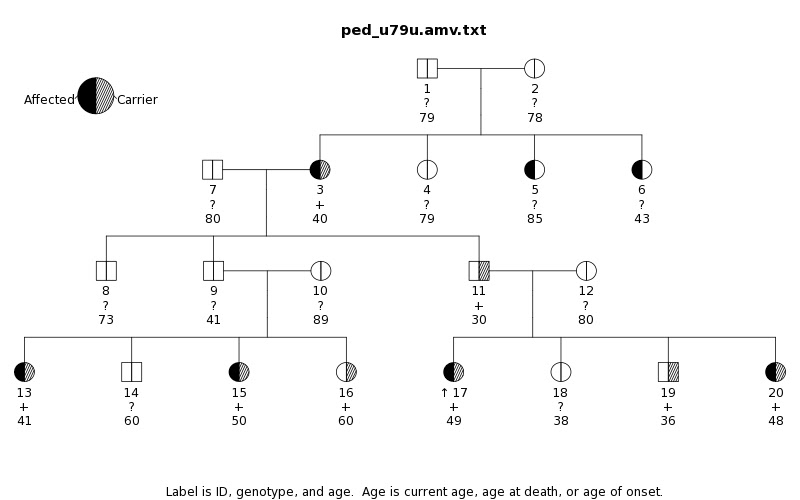

### Step 1: Examine the Penetrance file

We have set up the penetrance file to have 5 columns. The first column is for the risks for homozygous wild type genotype (1/1) for each sex and risk decade (penetrance class). The second column is for the risks for heterozyous genotype (1/2) by penetrance class.  The third column is for the risks for the homozygous high risk genotype (2/2) by penetrance class. The next column corresponds to the sex of the individual. The final column corresponds to the risk decade of the individual (1: $ 0 \le age \lt 20$, 2: $ 20 \le age \lt 30$, 3: $30 \le age \lt 40$, 4:  $40 \le age \lt 50$, 5:  $50 \le age \lt 60$, 6:  $60 \le age \lt 70$, and 7:  $70 \le age$).  

To view the file type:

In [ ]:
;cat PenBRCAExample.csv

### Step 2: Examine the pedigree file

In this example we are interested in determining the probability that individual 18, a 38 year old female who is currently unaffected with breast cancer is heterozygous for a BRCA1 mutation. In this case, some members of her family have genotypes at the locus.  

Like the previous example, the pedigree is present in two copies. The first copy (called Top) has the genotype of individual 18 as heterozygous. The second copy (called Bottom) has her genotype missing. The likelihood of the first pedigree divided by the likelihood of second pedigree gives us $P(G_{IV11} = 1/2| {\bf{G, Cancer Status, Age, Sex}})$, the "risk."


In [ ]:
;cat PedBRCAExample.csv

### Step 3: Examine the Locus and Phenotype File
These files are very similar to the ones we used in the first example.

In [ ]:
; cat LocusBRCAExample.txt

In [ ]:
; cat PhenoBRCAExample.txt

### Step 4: Examine the control file

This control file has some of the same features as parametric ones but it doesn't need to specify the GLM values because there is a penetrance file. Besides the input and output file names, the only needed information is the name of the Column in the pedigree that contains the information regarding breast cancer status. 

In [ ]:
;cat ControlBRCAexample.txt

### Step 5: Running the analysis

In [ ]:
using MendelGeneticCounseling 
GeneticCounseling("ControlBRCAexample.txt")

### Step 6: Interpreting the Result
Again you should get a file with the results.  The probability of that individual 18 is heterozygous is 0.45091.
 

### Step 7: Test yourself.  
(1) Modify the pedigree file and the control file to calculate the probability that individual 18 has the homozygous normal genotype.  Then rerun MendelGeneticCounseling with these new files.

(2) How would the risk change if individual 18 were 20 years old instead 38 years old?  What if she were 68 years old? (To determine, change her risk decade in the pedigrees and rerun the analysis). 


# Final Comments

The Julia version of Mendel, provides an opportunity for the user to easily modify the code to suit their own needs. All the source code is provided and Julia is both accessible and very fast.

### NOTE: When Finished with this notebook. Go to the File tab and first select save and checkpoint to save your results. Then under the file tab, select close and halt to prevent copies of Jupyter notebook from running indefinitely in the background